<a href="https://colab.research.google.com/github/mferiansyahrt/day_to_night_comparation/blob/main/deeplearning_method/UVCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define CycleGAN

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation,PReLU,UpSampling2D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Concatenate, Flatten, Reshape, Lambda, Dense
from tensorflow.keras.layers import LayerNormalization, Add, GroupNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras.activations import gelu

from os import listdir
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.utils import resample

from datetime import datetime
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2

from matplotlib import pyplot
import numpy as np
import shutil
from PIL import Image

In [ ]:
# !pip install --upgrade tensorflow keras

In [ ]:
# !git clone https://www.github.com/keras-team/keras-contrib.git

# #Download instance norm. code from the link above.
# #Or install keras_contrib using guidelines here: https://github.com/keras-team/keras-contrib
# #from instancenormalization import InstanceNormalization
# %cd keras-contrib
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape,stride):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=stride, padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=stride, padding='same', kernel_initializer=init)(d)
	d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=stride, padding='same', kernel_initializer=init)(d)
	d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=stride, padding='same', kernel_initializer=init)(d)
	d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=0.5)
	return model

In [ ]:
# # generator a resnet block to be used in the generator
# # residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
# def resnet_block(n_filters, input_layer):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# first convolutional layer
# 	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
# 	g = InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# second convolutional layer
# 	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
# 	g = InstanceNormalization(axis=-1)(g)
# 	# concatenate merge channel-wise with input layer
# 	g = Concatenate()([g, input_layer])
# 	return g

# # define the  generator model - encoder-decoder type architecture

# #c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1.
# #dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# # Rk denotes a residual block that contains two 3 × 3 convolutional layers
# # uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

# #The network with 6 residual blocks consists of:
# #c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

# #The network with 9 residual blocks consists of:
# #c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

# def define_generator(image_shape, n_resnet=9):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# image input
# 	in_image = Input(shape=image_shape)
# 	# c7s1-64
# 	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
# 	g = InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# d128
# 	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# d256
# 	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# R256
# 	for _ in range(n_resnet):
# 		g = resnet_block(256, g)
# 	# u128
# 	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# u64
# 	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# c7s1-3
# 	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
# 	g = InstanceNormalization(axis=-1)(g)
# 	out_image = Activation('tanh')(g)
# 	# define model
# 	model = Model(in_image, out_image)
# 	return model

In [ ]:
#U-Net ViT Generator

def basic_block(layer,numfilter,alpha_lrelu):
  l = GroupNormalization(groups = -1, axis=-1)(layer)
  l = Conv2D(numfilter,(3,3), strides = 1, padding = 'same')(l)
  l = LeakyReLU(alpha = alpha_lrelu)(l)
  return l

def down_sampling(layer,numfilter,layer_name):
  l = Conv2D(numfilter, (2,2), strides = 2, padding = 'same', name = layer_name)(layer)
  return l

def up_sampling(layer, numfilter,layer_name):
  l = Conv2DTranspose(numfilter, (3,3), strides = 2, padding = 'same', name = layer_name)(layer)
  return l

def positional_embedding(seq_length,dim):
  sequence_length = seq_length
  dimension = dim

  position = tf.range(0,sequence_length,1)[:,np.newaxis]
  position = tf.cast(position,tf.float32)

  even_pos = tf.cast(tf.range(0,dimension,2),tf.float32)
  odd_pos = tf.cast(tf.range(1,dimension,2),tf.float32)
  even_denominator = tf.pow(1000.0,(even_pos/tf.cast(dimension,tf.float32)))
  odd_denominator = tf.pow(1000.0,((odd_pos-1)/tf.cast(dimension,tf.float32)))
  denominator = even_denominator # actually even_denominator == odd_denominator

  even_PE = tf.math.sin(position/denominator)
  odd_PE = tf.math.cos(position/denominator)

  stacked = tf.stack([even_PE,odd_PE],axis = -1)

  PE = tf.reshape(stacked,[sequence_length,dimension])

  return PE

# BASIC BLOCK SEBELUM DOWN ATAU SESUDAH UP SAMPLING MASIH BISA DITAMBAH SATU JIKA MENGIKUTI PAPER (SUDAH DITAMBAHKAN)

def unet_vit_generator(image_shape,num_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu):
  in_image = Input(shape = image_shape)

  # ---- preprocess ----
  x = Conv2D(64, (2,2), padding ='same', name = 'preprocess')(in_image)
  x = LeakyReLU(alpha = alpha_lrelu)(x)

  # ---- ENCODER PART ----
  #first block
  x = basic_block(x, num_features, alpha_lrelu)
  x_d1 = basic_block(x, num_features, alpha_lrelu)
  x = down_sampling(x_d1, num_features, 'down_1')

  #second block
  x = basic_block(x, num_features*2, alpha_lrelu)
  x_d2 = basic_block(x,num_features*2, alpha_lrelu)
  x = down_sampling(x_d2,num_features*2,'down_2')

  #third block
  x = basic_block(x, num_features*4, alpha_lrelu)
  x_d3 = basic_block(x,num_features*4, alpha_lrelu)
  x = down_sampling(x_d3,num_features*4,'down_3')

  #fourth block
  x = basic_block(x, num_features*8, alpha_lrelu)
  x_d4 = basic_block(x, num_features*8, alpha_lrelu)
  x = down_sampling(x_d4, num_features*8, 'down_4')
  flatten_shape = x.shape

  # ---- pixel-wise ViT ----
  x = Reshape((flatten_shape[1]*flatten_shape[2],flatten_shape[3]))(x)

  # Define Positional Encoding layer (256,512) by default
  PE = positional_embedding(flatten_shape[1]*flatten_shape[2],num_features*8) #Should be normalized later according to LeakyReLU range
  PE = LeakyReLU(alpha = alpha_lrelu)(PE)
  PE_layer = tf.expand_dims(PE, axis=0)

  class RepeatLayer(Layer):
      def __init__(self, axis=0, **kwargs):
          super(RepeatLayer, self).__init__(**kwargs)
          self.axis = axis

      def call(self, inputs, x):
          repeat_times = tf.shape(x)[0]  # Get the batch size dynamically from 'x'
          return tf.repeat(inputs, repeat_times, axis=self.axis)

      def get_config(self):
          config = super().get_config().copy()
          config.update({
              'axis': self.axis
          })
          return config

  # Custom repeat layer instead of tf.repeat
  PE_layer = RepeatLayer(axis=0)(PE_layer, x)

  # Concatenate positional encoding with input
  x = Concatenate(axis=2)([x, PE_layer])
  x = Dense(num_features * 8)(x)


  # Transformer Encoder Block
  for n in range(transformer_block):
    x_l = LayerNormalization(epsilon = 1e-6)(x)
    x = MultiHeadAttention(num_heads = n_attention_head, key_dim = num_features, dropout = 0.1)(x_l,x_l)
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha_reg) * x
    x = Add()([x_l,x])
    x_l2 = LayerNormalization(epsilon = 1e-6)(x)

    # FFN
    x = Dense(4*num_features*8, activation = 'gelu')(x_l2) # masih salah (seharusnya (512,2048))
    x = Dense(num_features*8)(x)                           # masih salah(seharusnya (2048,512))
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha_reg) * x
    x = Add()([x_l2,x])

  x = Dense(num_features*8)(x)
  x = Reshape((flatten_shape[1],flatten_shape[2],flatten_shape[3]))(x)

  # ---- DECODER PART ----
  #first block
  x = up_sampling(x,num_features*8,'up_1')
  x = Concatenate()([x, x_d4])
  x = basic_block(x,num_features*8, alpha_lrelu)
  x = basic_block(x,num_features*8, alpha_lrelu)

  #second block
  x = up_sampling(x,num_features*4,'up_2')
  x = Concatenate()([x, x_d3])
  x = basic_block(x,num_features*4, alpha_lrelu)
  x = basic_block(x,num_features*4, alpha_lrelu)

  #third block
  x = up_sampling(x,num_features*2,'up_3')
  x = Concatenate()([x, x_d2])
  x = basic_block(x,num_features*2, alpha_lrelu)
  x = basic_block(x,num_features*2, alpha_lrelu)

  #fourth block
  x = up_sampling(x,num_features,'up_4')
  x = Concatenate()([x, x_d1])
  x = basic_block(x,num_features, alpha_lrelu)
  x = basic_block(x,num_features, alpha_lrelu)

  # ---- postprocess ----
  x = Conv2D(3, (1,1), padding='same')(x)
  x = GroupNormalization(groups = -1, axis=-1)(x)
  out_image = Activation('tanh')(x)

  # # ---- postprocess ----
  # x = Conv2D(3, (1,1), padding='same')(x)
  # x = GroupNormalization(groups = -1, axis=-1)(x)
  # x = Activation('relu')(x)

  # x = upscale_block(x,2)

  # x = Conv2D(128,(3,3),padding = 'same')(x)
  # x = GroupNormalization(groups = -1, axis=-1)(x)
  # x = Activation('relu')(x)

  # x = Conv2D(64,(3,3),padding = 'same')(x)
  # x = GroupNormalization(groups = -1, axis=-1)(x)
  # x = Activation('relu')(x)

  # x = Conv2D(3,(9,9),padding = 'same')(x)
  # x = GroupNormalization(groups = -1, axis=-1)(x)
  # out_image = Activation('tanh')(x)

  m = Model(in_image,out_image)
  return m

def upscale_block(x,factor):

  up_model = Conv2D(256, (3,3), padding="same")(x)
  up_model = UpSampling2D( size = factor )(up_model)
  up_model = PReLU(shared_axes=[1,2])(up_model)

  return up_model
#def unet_vit_generator(image_shape,num_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu):
#   in_image = Input(shape = image_shape)

#   # ---- preprocess ----
#   x = Conv2D(64, (2,2), padding ='same', name = 'preprocess')(in_image)
#   x = LeakyReLU(alpha = alpha_lrelu)(x)

#   # ---- ENCODER PART ----
#   #first block
#   x = basic_block(x, num_features, alpha_lrelu)
#   x_d1 = basic_block(x, num_features, alpha_lrelu)
#   x = down_sampling(x_d1, num_features, 'down_1')

#   #second block
#   x = basic_block(x, num_features*2, alpha_lrelu)
#   x_d2 = basic_block(x,num_features*2, alpha_lrelu)
#   x = down_sampling(x_d2,num_features*2,'down_2')

#   #third block
#   x = basic_block(x, num_features*4, alpha_lrelu)
#   x_d3 = basic_block(x,num_features*4, alpha_lrelu)
#   x = down_sampling(x_d3,num_features*4,'down_3')

#   #fourth block
#   x = basic_block(x, num_features*8, alpha_lrelu)
#   x_d4 = basic_block(x, num_features*8, alpha_lrelu)
#   x = down_sampling(x_d4, num_features*8, 'down_4')
#   flatten_shape = x.shape

#   # ---- pixel-wise ViT ----
#   x = Reshape((flatten_shape[1]*flatten_shape[2],flatten_shape[3]))(x)

#   # Define Positional Encoding layer (256,512) by default
#   PE = positional_embedding(flatten_shape[1]*flatten_shape[2],num_features*8) #Should be normalized later according to LeakyReLU range
#   PE = LeakyReLU(alpha = alpha_lrelu)(PE)
#   PE_layer = tf.expand_dims(PE, axis=0)
#   PE_layer = tf.repeat(PE_layer, tf.shape(x)[0], axis=0)

#   x = Concatenate(axis = 2)([x,PE_layer])
#   x = Dense(num_features*8)(x)

#   # Transformer Encoder Block
#   for n in range(transformer_block):
#     x_l = LayerNormalization(epsilon = 1e-6)(x)
#     x = MultiHeadAttention(num_heads = n_attention_head, key_dim = num_features, dropout = 0.1)(x_l,x_l)
#     # Rezero regularization Output = SkipConnection + α⋅MainPath
#     x = tf.constant(alpha_reg) * x
#     x = Add()([x_l,x])
#     x_l2 = LayerNormalization(epsilon = 1e-6)(x)

#     # FFN
#     x = Dense(4*num_features*8, activation = 'gelu')(x_l2) # masih salah (seharusnya (512,2048))
#     x = Dense(num_features*8)(x)                           # masih salah(seharusnya (2048,512))
#     # Rezero regularization Output = SkipConnection + α⋅MainPath
#     x = tf.constant(alpha_reg) * x
#     x = Add()([x_l2,x])

#   x = Dense(num_features*8)(x)
#   x = Reshape((flatten_shape[1],flatten_shape[2],flatten_shape[3]))(x)

#   # ---- DECODER PART ----
#   #first block
#   x = up_sampling(x,num_features*8,'up_1')
#   x = Concatenate()([x, x_d4])
#   x = basic_block(x,num_features*8, alpha_lrelu)
#   x = basic_block(x,num_features*8, alpha_lrelu)

#   #second block
#   x = up_sampling(x,num_features*4,'up_2')
#   x = Concatenate()([x, x_d3])
#   x = basic_block(x,num_features*4, alpha_lrelu)
#   x = basic_block(x,num_features*4, alpha_lrelu)

#   #third block
#   x = up_sampling(x,num_features*2,'up_3')
#   x = Concatenate()([x, x_d2])
#   x = basic_block(x,num_features*2, alpha_lrelu)
#   x = basic_block(x,num_features*2, alpha_lrelu)

#   #fourth block
#   x = up_sampling(x,num_features,'up_4')
#   x = Concatenate()([x, x_d1])
#   x = basic_block(x,num_features, alpha_lrelu)
#   x = basic_block(x,num_features, alpha_lrelu)

#   # ---- postprocess ----
#   x = Conv2D(3, (1,1), padding='same')(x)
#   x = GroupNormalization(groups = -1, axis=-1)(x)
#   out_image = Activation('tanh')(x)

#   m = Model(in_image,out_image)
#   return m

In [ ]:
# image_shape = dataset[0].shape[1:]
# n_features = 128 #64
# n_attention_head = 12 #10
# transformer_block = 12 #12
# alpha_reg = 0.00001
# alpha_lrelu = 0.01

# g_model_AtoB = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)

In [ ]:
# g_model_AtoB.summary()

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately.
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time.
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False

	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

    # define the optimizer
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1.
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0.
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA, c_model_AtoB = None, c_model_BtoA = None, \
                d_model_A = None, d_model_B = None, save_weight = False,target_step = None, \
								save_composite_model = False, save_gnd = True):
	if save_weight == False:
		# save the first generator model
		filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
		g_model_AtoB.save(filename1)
		# save the second generator model
		filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
		g_model_BtoA.save(filename2)
		print('>Saved: %s and %s' % (filename1, filename2))
	elif save_weight == True:
		if save_gnd == True:
			# save the first generator model
			filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
			g_model_AtoB.save_weights(filename1)
			# save the second generator model
			filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
			g_model_BtoA.save_weights(filename2)
			# save the discriminator model A
			filename5 = 'd_model_A_%06d.h5' % (step+1)
			d_model_A.save_weights(filename5)
			# save the discriminator model B
			filename6 = 'd_model_B_%06d.h5' % (step+1)
			d_model_B.save_weights(filename6)
		elif save_gnd == False:
			filename1 = 'skip saving AtoB generator model on iteration %06d' %(step+1)
			filename2 = 'skip saving BtoA generator model on iteration %06d' %(step+1)
			filename5 = 'skip saving AtoB discriminator model on iteration %06d' %(step+1)
			filename6 = 'skip saving BtoA discriminator model on iteration %06d' %(step+1)

		if save_composite_model == True:
			# save the composite model AtoB for resuming training
			filename3 = 'c_model_AtoB_%06d.h5' % (step+1)
			c_model_AtoB.save_weights(filename3)
			# save the composite model BtoA for resuming training
			filename4 = 'c_model_BtoA_%06d.h5' % (step+1)
			c_model_BtoA.save_weights(filename4)
		elif save_composite_model == False:
			filename3 = 'skip saving AtoB composite model on iteration %06d' %(step+1)
			filename4 = 'skip saving BtoA composite model on iteration %06d' %(step+1)

		print('>Saved: %s, %s, %s, %s, %s, and %s' % (filename1, filename2, filename3, filename4, filename5, filename6))

		if step + 1 == target_step:
			# save the first generator model
			filename1 = 'generator_day2night_%06d.h5' % (step+1)
			g_model_AtoB.save(filename1)
			# save the second generator model
			filename2 = 'generator_night2day_%06d.h5' % (step+1)
			g_model_BtoA.save(filename2)
			print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores
#the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1, resume_train = True,\
          path_gAtoB = None, path_gBtoA = None, path_cAtoB = None, path_cBtoA = None, path_dA = None, path_dB = None,\
					iter_index = None):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	if resume_train == False:
		# manually enumerate epochs
		for i in range(n_steps):
			# select a batch of real samples from each domain (A and B)
			X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
			X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
			# generate a batch of fake samples using both B to A and A to B generators.
			X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
			X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
			# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
			X_fakeA = update_image_pool(poolA, X_fakeA)
			X_fakeB = update_image_pool(poolB, X_fakeB)

			# update generator B->A via the composite model
			g_loss2, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
			# update discriminator for A -> [real/fake]
			dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
			dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

			# update generator A->B via the composite model
			g_loss1, _= c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
			# update discriminator for B -> [real/fake]
			dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
			dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

					# summarize performance
					#Since our batch size =1, the number of iterations would be same as the size of our dataset.
					#In one epoch you'd have iterations equal to the number of images.
					#If you have 100 images then 1 epoch would be 100 iterations
			print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
			# evaluate the model performance periodically
					#If batch size (total images)=100, performance will be summarized after every 75th iteration.
			if (i+1) % (bat_per_epo * 1) == 0:
				# plot A->B translation
				summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
				# plot B->A translation
				summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
			if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
				# save the models
							# #If batch size (total images)=100, model will be saved after
							#every 75th iteration x 5 = 375 iterations.
				save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B,save_weight = True,
				            target_step = n_steps,save_composite_model = False,save_gnd = True)
			if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
				# save the models
							# #If batch size (total images)=100, model will be saved after
							#every 75th iteration x 5 = 375 iterations.
				save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B,save_weight = True,
				            target_step = n_steps,save_composite_model = True,save_gnd = False)

	elif resume_train == True:
		g_model_BtoA.load_weights(path_gBtoA)
		g_model_AtoB.load_weights(path_gAtoB)

		c_model_BtoA.load_weights(path_cBtoA)
		c_model_AtoB.load_weights(path_cAtoB)

		d_model_A.load_weights(path_dA)
		d_model_B.load_weights(path_dB)
		print(f'Resuming Training After {int(iter_index/bat_per_epo)} Epoch on Previous Training \n')

		for j in range(n_steps):
			i = j + iter_index
			# select a batch of real samples from each domain (A and B)
			X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
			X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
			# generate a batch of fake samples using both B to A and A to B generators.
			X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
			X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
			# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
			X_fakeA = update_image_pool(poolA, X_fakeA)
			X_fakeB = update_image_pool(poolB, X_fakeB)

			# update generator B->A via the composite model
			g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
			# update discriminator for A -> [real/fake]
			dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
			dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

			# update generator A->B via the composite model
			g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
			# update discriminator for B -> [real/fake]
			dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
			dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

					# summarize performance
					#Since our batch size =1, the number of iterations would be same as the size of our dataset.
					#In one epoch you'd have iterations equal to the number of images.
					#If you have 100 images then 1 epoch would be 100 iterations
			print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
			# evaluate the model performance periodically
					#If batch size (total images)=100, performance will be summarized after every 75th iteration.
			if (i+1) % (bat_per_epo * 1) == 0:
				# plot A->B translation
				summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
				# plot B->A translation
				summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
			if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
				# save the models
							# #If batch size (total images)=100, model will be saved after
							#every 75th iteration x 5 = 375 iterations.
				save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B,save_weight = True,
				            target_step = n_steps + iter_index)

# CREATE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# for i in range(169,13520+169,169):
#   s = 'a_' + 'c_model_AtoB_%06d.h5' % (i)
#   print(s)

In [ ]:
# import os

# def remove_file(file_path):
#   # Check if the file exists before deleting
#   if os.path.exists(file_path):
#       os.remove(file_path)
#       print(f'File {file_path} has been deleted.')
#   else:
#       print(f'File {file_path} does not exist.')

# main_path = '/content/gdrive/MyDrive/weight_only_UVCGAN_EdgeLoss_olddata_169im_resumeTrain_withoutPretrainedEdgeWeight/'
# # Specify the path to the file you want to delete

# for i in range(169,16393+169,169):
#   c_BtoA = main_path + 'c_model_BtoA_%06d.h5' %(i)
#   c_AtoB = main_path + 'c_model_BtoA_%06d.h5' %(i)
#   d_A = main_path + 'd_model_A_%06d.h5' %(i)
#   d_B = main_path + 'd_model_B_%06d.h5' %(i)
#   g_AtoB = main_path + 'g_model_AtoB_%06d.h5' %(i)
#   g_BtoA = main_path + 'g_model_BtoA_%06d.h5' %(i)

#   remove_file(c_BtoA)
#   remove_file(c_AtoB)
#   remove_file(d_A)
#   remove_file(d_B)
#   remove_file(g_AtoB)
#   remove_file(g_BtoA)



In [ ]:
'''!mkdir /content/monet2photo/
%cd /content/monet2photo/
!unzip /content/gdrive/MyDrive/monet2photo.zip'''

'!mkdir /content/monet2photo/\n%cd /content/monet2photo/\n!unzip /content/gdrive/MyDrive/monet2photo.zip'

In [ ]:
!mkdir /content/day2night/
%cd /content/day2night/
#!unzip /content/gdrive/MyDrive/day2night_bdd_ip2.zip # Dataset campuran yang baru
!unzip /content/gdrive/MyDrive/day2night_bdd_ip.zip # Dataset campuran yang lama
#!unzip /content/gdrive/MyDrive/day2night.zip # Dataset asli

/content/day2night
Archive:  /content/gdrive/MyDrive/day2night_bdd_ip.zip
   creating: trainDay/
  inflating: trainDay/6a729de1-7adc57f8.jpg  
  inflating: __MACOSX/trainDay/._6a729de1-7adc57f8.jpg  
  inflating: trainDay/Image_15.jpg   
  inflating: trainDay/Image_29.jpg   
  inflating: trainDay/1c1de1e7-346d6219.jpg  
  inflating: __MACOSX/trainDay/._1c1de1e7-346d6219.jpg  
  inflating: trainDay/6ad23488-70abed67.jpg  
  inflating: __MACOSX/trainDay/._6ad23488-70abed67.jpg  
  inflating: trainDay/6a626ee3-61100bbc.jpg  
  inflating: __MACOSX/trainDay/._6a626ee3-61100bbc.jpg  
  inflating: trainDay/0f145ef9-2fb016d0.jpg  
  inflating: __MACOSX/trainDay/._0f145ef9-2fb016d0.jpg  
  inflating: trainDay/00f7eac8-5193d600.jpg  
  inflating: __MACOSX/trainDay/._00f7eac8-5193d600.jpg  
  inflating: trainDay/Image_28.jpg   
  inflating: trainDay/Image_14.jpg   
  inflating: trainDay/1a2f2112-f566a272.jpg  
  inflating: __MACOSX/trainDay/._1a2f2112-f566a272.jpg  
  inflating: trainDay/0a0c3694

In [ ]:
'''# monet2photo

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = '/content/monet2photo/archive/'

# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all,
                 replace=False,
                 n_samples=500,
                 random_state=42)
print(f'Use Monet paintings (dataA) with total of {dataA.shape[0]} images for training')

# load dataset B - Photos
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataB = resample(dataB_all,
                 replace=False,
                 n_samples=500,
                 random_state=42)
print(f'Use Photos (dataB) with total of {dataB.shape[0]} images for training')
'''

"# monet2photo\n\n# load all images in a directory into memory\ndef load_images(path, size=(256,256)):\n\tdata_list = list()\n\t# enumerate filenames in directory, assume all are images\n\tfor filename in listdir(path):\n\t\t# load and resize the image\n\t\tpixels = load_img(path + filename, target_size=size)\n\t\t# convert to numpy array\n\t\tpixels = img_to_array(pixels)\n\t\t# store\n\t\tdata_list.append(pixels)\n\treturn asarray(data_list)\n\n# dataset path\npath = '/content/monet2photo/archive/'\n\n# load dataset A - Monet paintings\ndataA_all = load_images(path + 'trainA/')\nprint('Loaded dataA: ', dataA_all.shape)\n\n#To get a subset of all images, for faster training during demonstration\ndataA = resample(dataA_all,\n                 replace=False,\n                 n_samples=500,\n                 random_state=42)\nprint(f'Use Monet paintings (dataA) with total of {dataA.shape[0]} images for training')\n\n# load dataset B - Photos\ndataB_all = load_images(path + 'trainB/')\npr

In [ ]:
import os

os.remove('/content/day2night/trainDay/.DS_Store')
os.remove('/content/day2night/trainNight/.DS_Store')

day = sorted(os.listdir('/content/day2night/trainDay/'))
night = sorted(os.listdir('/content/day2night/trainNight/'))

In [ ]:
len(day),len(night)

(169, 169)

In [ ]:
# bdd_day2night

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = '/content/day2night/'

# load dataset A - day
dataA_all = load_images(path + 'trainDay/')
print('Loaded dataA: ', dataA_all.shape)

#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all,
                 replace=False,
                 n_samples=len(day),
                 random_state=42)
print(f'Use Day Images (dataA) with total of {dataA.shape[0]} images for training')

# load dataset B - night
dataB_all = load_images(path + 'trainNight/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataB = resample(dataB_all,
                 replace=False,
                 n_samples=len(night),
                 random_state=42)
print(f'Use Night Images (dataB) with total of {dataB.shape[0]} images for training')


Loaded dataA:  (169, 256, 256, 3)
Use Day Images (dataA) with total of 169 images for training
Loaded dataB:  (169, 256, 256, 3)
Use Night Images (dataB) with total of 169 images for training


In [ ]:
# # bdd_day2night

# # load all images in a directory into memory
# def load_images(path, size=(256,256)):
# 	data_list = list()
# 	# enumerate filenames in directory, assume all are images
# 	for filename in listdir(path):
# 		# load and resize the image
# 		pixels = load_img(path + filename, target_size=size)
# 		# convert to numpy array
# 		pixels = img_to_array(pixels)
# 		# store
# 		data_list.append(pixels)
# 	return asarray(data_list)

# # dataset path
# path_HR = '/content/day2night/'

# # load dataset night HIGH RESOLUTION (HR) -- TARGET
# dataHR_all = load_images(path_HR + 'trainNight/')
# print('Loaded dataHR: ', dataHR_all.shape)
# #Get a subset of all images, for faster training during demonstration
# #We could have just read the list of files and only load a subset, better memory management.
# dataHR = resample(dataHR_all,
#                  replace=False,
#                  n_samples=len(night),
#                  random_state=42)
# print(f'Use Real Night HR Images(dataHR) with total of {dataHR.shape[0]} images for training')

# # load dataset night LOW RESOLUTION (LR) -- FEATURE
# path_lr = '/content/gdrive/MyDrive/night_generated_uvcgan/'
# dataLR_all = load_images(path_lr + 'night/', size=(256,256))
# print('Loaded dataLR: ', dataLR_all.shape)
# #Get a subset of all images, for faster training during demonstration
# #We could have just read the list of files and only load a subset, better memory management.
# dataLR = resample(dataLR_all,
#                  replace=False,
#                  n_samples=len(night),
#                  random_state=42)
# print(f'Use Synthetic Night Generated LR Images (dataLR) with total of {dataLR.shape[0]} images for training')

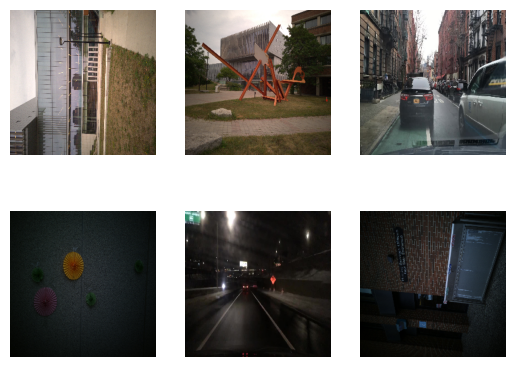

Loaded (169, 256, 256, 3) (169, 256, 256, 3)


In [ ]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

def preprocess_data_input_edge(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [0,1]
	X1 = (X1) / 255.0
	X2 = (X2) / 255.0
	return [X1, X2]

dataset = preprocess_data(data)

In [ ]:
# # plot source images
# n_samples = 4
# for i in range(n_samples):
# 	plt.subplot(2, n_samples, 1 + i)
# 	plt.axis('off')
# 	plt.imshow(dataLR[i].astype('uint8'))
# # plot target image
# for i in range(n_samples):
# 	plt.subplot(2, n_samples, 1 + n_samples + i)
# 	plt.axis('off')
# 	plt.imshow(dataHR[i].astype('uint8'))
# plt.show()

# # load image data
# data = [dataLR, dataHR]

# print('Loaded', data[0].shape, data[1].shape)

# #Preprocess data to change input range to values between -1 and 1
# # This is because the generator uses tanh activation in the output layer
# #And tanh ranges between -1 and 1
# def preprocess_data(data):
# 	# load compressed arrays
# 	# unpack arrays
# 	X1, X2 = data[0], data[1]
# 	# scale from [0,255] to [-1,1]
# 	X1 = (X1 - 127.5) / 127.5
# 	X2 = (X2 - 127.5) / 127.5
# 	return [X1, X2]

# def preprocess_data_input_edge(data):
# 	# load compressed arrays
# 	# unpack arrays
# 	X1, X2 = data[0], data[1]
# 	# scale from [0,255] to [0,1]
# 	X1 = (X1) / 255.0
# 	X2 = (X2) / 255.0
# 	return [X1, X2]

# dataset = preprocess_data(data)

# TRAINING

In [ ]:
image_shape = dataset[0].shape[1:]
num_features = 128 #64
n_attention_head = 12 #10
transformer_block = 12 #12
alpha_reg = 0.00001
alpha_lrelu = 0.01

In [ ]:
# define input shape based on the loaded dataset

image_shape = dataset[0].shape[1:]
n_features = 128 #64
n_attention_head = 12 #10
transformer_block = 12 #12
alpha_reg = 0.00001
alpha_lrelu = 0.01

#generator = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)
# generator: A -> B
g_model_AtoB = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)
# generator: B -> A
g_model_BtoA = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape,2)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape,2)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
a = dataset[0][0:20]
b = dataset[1][0:20]
dataset_test = [a,b]

In [ ]:
# save hasil train ke folder dibawah

!mkdir /content/train_CycleGAN100ep_LRtoCLR_CLRtoLR/
%cd /content/train_CycleGAN100ep_LRtoCLR_CLRtoLR/

/content/train_CycleGAN100ep_LRtoCLR_CLRtoLR


In [ ]:
start1 = datetime.now()
resume_train = False

if resume_train == False:
  epoch = 10
  # train models
  train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset_test, epochs = epoch,resume_train = resume_train)

elif resume_train == True:
  # train models

  n_sample_iter = 2660   # check the file iteration number
  target_epoch = 100    # if we want to train on 100 epoch, but it stopped on 50 epoch on previous training, then the target_epoch is 100
  current_epoch = int(n_sample_iter/len(day))
  new_epoch = target_epoch - current_epoch
  print(f'Current Training with {int(new_epoch)} Epoch with target of {target_epoch} Epoch')

  weight_path = '/content/gdrive/MyDrive/weight_only/'

  path_gAtoB = weight_path + 'g_model_AtoB_%06d.h5' % (n_sample_iter)
  path_gBtoA = weight_path + 'g_model_BtoA_%06d.h5' % (n_sample_iter)

  path_cAtoB = weight_path + 'c_model_AtoB_%06d.h5' % (n_sample_iter)
  path_cBtoA = weight_path + 'c_model_BtoA_%06d.h5' % (n_sample_iter)

  path_dA = weight_path + 'd_model_A_%06d.h5' % (n_sample_iter)
  path_dB = weight_path + 'd_model_B_%06d.h5' % (n_sample_iter)

  train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=new_epoch, resume_train = resume_train,\
        path_gAtoB = path_gAtoB, path_gBtoA = path_gBtoA, path_cAtoB = path_cAtoB, path_cBtoA = path_cBtoA, \
        path_dA = path_dA, path_dB = path_dB,iter_index = n_sample_iter)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Iteration>1, dA[1.502,1.094] dB[0.886,0.752] g[0.000,0.000]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iteration>2, dA[1.269,1.151] dB[0.764,0.750] g[0.752,1.094]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Iteration>3, dA[1.252,1.144] dB[0.783,0.763] g[0.750,1.151]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Iteration>4, dA[1.207,1.136] dB[0.810,0.789] g[0.763,1.144]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Iteration>5, dA[1.205,1.154] dB[0.800,0.804] g[0.789,1.136]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Iteration>6, dA[1.209,1.145] dB[0.802,0.806] g[0.804,1.154]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Iteration>7, dA[1.177,1.138] dB[0.819,0.809] g[0.806,1.145]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Iteration>8, dA[1.165,1.129] dB[0.809,0.809] g[0

ValueError: The filename must end in `.weights.h5`. Received: filepath=g_model_AtoB_000100.h5

In [ ]:
iter = 14500

g_AtoB = 'g_model_AtoB_%06d.h5' %(iter)
g_BtoA = 'g_model_BtoA_%06d.h5' %(iter)

c_AtoB = 'c_model_AtoB_%06d.h5' %(iter)
c_BtoA = 'c_model_BtoA_%06d.h5' %(iter)

d_A = 'd_model_A_%06d.h5' %(iter)
d_B = 'd_model_B_%06d.h5' %(iter)

path_origin = '/content/train_CycleGAN100ep/'

p_g_AtoB = path_origin + g_AtoB
p_g_BtoA = path_origin + g_BtoA
p_c_AtoB = path_origin + c_AtoB
p_c_BtoA = path_origin + c_BtoA
p_d_A = path_origin + d_A
p_d_B = path_origin + d_B

path_copy = '/content/gdrive/MyDrive/weight_only_UVCGAN_newdata/'

pc_g_AtoB = path_copy + g_AtoB
pc_g_BtoA = path_copy + g_BtoA
pc_c_AtoB = path_copy + c_AtoB
pc_c_BtoA = path_copy + c_BtoA
pc_d_A = path_copy + d_A
pc_d_B = path_copy + d_B

%cp {p_g_AtoB} {pc_g_AtoB}
%cp {p_g_BtoA} {pc_g_BtoA}
%cp {p_c_AtoB} {pc_c_AtoB}
%cp {p_c_BtoA} {pc_c_BtoA}
%cp {p_d_A} {pc_d_A}
%cp {p_d_B} {pc_d_B}


# SAVE GAMBAR

In [ ]:
path = '/content/train_CycleGAN100ep/'

png = os.listdir(path)

In [ ]:
!mkdir /content/gdrive/MyDrive/Example_Training_MAE_UVCGAN_NEWDATA

In [ ]:
target_path = '/content/gdrive/MyDrive/Example_Training_MAE_UVCGAN_NEWDATA/'

for image in png:
  if '.png' in image:
    image_path = path+image
    shutil.copy(image_path,target_path + image)

# INFERENCE

In [ ]:
def calculate_euclidean_distance(color1, color2):
    r_diff = color1[0] - color2[0]
    g_diff = color1[1] - color2[1]
    b_diff = color1[2] - color2[2]

    distance = np.sqrt(r_diff**2 + g_diff**2 + b_diff**2)
    return distance

def calculate_cie76_color_difference(color1, color2):
    gray1 = 0.299 * color1[0] + 0.587 * color1[1] + 0.114 * color1[2]
    gray2 = 0.299 * color2[0] + 0.587 * color2[1] + 0.114 * color2[2]

    delta_e = np.abs(gray1 - gray2)

    return delta_e,np.mean(delta_e)

############################################

# Use the saved cyclegan models for image translation
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2,save,save_path = None):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	pyplot.figure(figsize=(12,8))
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()
	if save:
		pyplot.savefig(save_path)
	else:
		save_path = None

In [ ]:
# INI YANG EDGELOSS NANTI GANTI AJA MENGACU WEIGHT PATH KE KODINGAN Day2Night_Metrics.ipnyb
weight_path_d2n = '/content/gdrive/MyDrive/train_CycleGAN100ep_UVCGAN_EdgeLoss_ResumeTraining/g_model_BtoA_033462.h5'
weight_path_n2d = '/content/gdrive/MyDrive/train_CycleGAN100ep_UVCGAN_EdgeLoss_ResumeTraining/g_model_AtoB_033462.h5'

image_shape = dataset[0].shape[1:]
n_features = 128 #64
n_attention_head = 24 #10
transformer_block = 12 #12
alpha_reg = 0.00001
alpha_lrelu = 0.01

#generator = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)
# generator: A -> B
model_d2n = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)
# generator: B -> A
model_n2d = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)

model_d2n.load_weights(weight_path_d2n)
model_n2d.load_weights(weight_path_n2d)

In [ ]:
sampel = 123
save = False
'''
#Night to Day to Night
#test_image = load_img('/content/bdd_daynight/night/0096bcca-c2027ec4.jpg',target_size=(256,256))
test_image = load_img(f'/content/day2night/trainNight/0096bcca-c2027ec4.jpg',target_size=(256,256))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
day_generated  = model_n2d.predict(test_image_input)
night_reconstructed = model_d2n.predict(day_generated)
print('NIGHT TO DAY TO NIGHT')
#save_path = f'/content/gdrive/MyDrive/n2d2n_model_{int(num_model/len(day))}ep_{sampel}.jpg'
save_path = f'/content/gdrive/MyDrive/a.jpg'
show_plot(test_image_input, day_generated, night_reconstructed,save,save_path)

night_real = test_image.astype(np.uint8)
night_rec = (((night_reconstructed[0] + 1)/2.0)*255).astype(np.uint8)
difference_night_identity, mean_difference_night_identity  = calculate_cie76_color_difference(night_real,night_rec)
print(f'∆E night identity {mean_difference_night_identity}\n')
'''
num = 5
#Day to Night to Day
test_image = load_img(f'/content/gdrive/MyDrive/sample_citra_report3/gt_{num}.jpg',target_size=(256,256))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
night_generated  = model_d2n.predict(test_image_input)
day_reconstructed = model_n2d.predict(night_generated)
print('DAY TO NIGHT TO DAY')
#save_path = f'/content/gdrive/MyDrive/d2n2d_model_{int(num_model/len(day))}ep_{sampel}.jpg'
save_path = f'/content/gdrive/MyDrive/b.jpg'
show_plot(test_image_input, night_generated, day_reconstructed,save,save_path)

day_real = test_image.astype(np.uint8)
day_rec = (((day_reconstructed[0] + 1)/2.0)*255).astype(np.uint8)
difference_day_identity, mean_difference_day_identity = calculate_cie76_color_difference(day_real,day_rec)
print(f'∆E day identity {mean_difference_day_identity}')

In [ ]:
gt = ((test_image_input[0] + 1) / 2.0)*255.0
gt = cv2.cvtColor(gt,cv2.COLOR_BGR2RGB)
cv2.imwrite(f'/content/gdrive/MyDrive/sample_citra_report3/gt_{num}.jpg', gt.astype(np.uint8))

gen = ((night_generated[0] + 1) / 2.0)*255.0
gen = cv2.cvtColor(gen,cv2.COLOR_BGR2RGB)
cv2.imwrite(f'/content/gdrive/MyDrive/sample_citra_report3/generated_{num}_UVCGAN_EdgeLoss.jpg', gen.astype(np.uint8))


In [ ]:
model_d2n.summary()

In [ ]:
MAH = model_d2n.get_layer(name = 'leaky_re_lu_17').output

model = Model(inputs = model_d2n.input, outputs = MAH)

#Day to Night to Day
test_image = load_img(f'/content/day2night/trainDay/00a395fe-d60c0b47.jpg',target_size=(256,256))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
night_generated  = model.predict(test_image_input)
#night_generated = (night_generated + 1) / 2.0

plt.imshow(night_generated[0][:,:,42])
plt.axis('off')

In [ ]:
model_d2n = '/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_AtoB_003500.h5'
model_n2d = '/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_BtoA_003500.h5'

# load dataset
A_data = resample(dataA_all,
                 replace=False,
                 n_samples=50,
                 random_state=42) # reproducible results

B_data = resample(dataB_all,
                 replace=False,
                 n_samples=50,
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model(model_d2n, cust)
model_BtoA = load_model(model_n2d, cust)

# plot A->B->A (Day to Night to Day)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed,False)
# plot B->A->B (Night to Day to Night)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed,False)


In [ ]:
sampel = 45
save = False

##########################
#Load a single custom image

num_model = 3500
model_d2n = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_AtoB_00{num_model}.h5'
model_n2d = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_BtoA_00{num_model}.h5'

# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model(model_d2n, cust)
model_BtoA = load_model(model_n2d, cust)
print(f'\nGenerator after {int(num_model/len(day))} EPOCH\n')

#Night to Day to Night
#test_image = load_img('/content/bdd_daynight/night/0096bcca-c2027ec4.jpg',target_size=(256,256))
test_image = load_img(f'/content/day2night/trainNight/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
day_generated  = model_BtoA.predict(test_image_input)
night_reconstructed = model_AtoB.predict(day_generated)
print('NIGHT TO DAY TO NIGHT')
save_path = f'/content/gdrive/MyDrive/n2d2n_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, day_generated, night_reconstructed,save,save_path)

night_real = test_image.astype(np.uint8)
night_rec = (((night_reconstructed[0] + 1)/2.0)*255).astype(np.uint8)
difference_night_identity, mean_difference_night_identity  = calculate_cie76_color_difference(night_real,night_rec)
print(f'∆E night identity {mean_difference_night_identity}\n')

#Day to Night to Day
test_image = load_img(f'/content/day2night/trainDay/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
night_generated  = model_AtoB.predict(test_image_input)
day_reconstructed = model_BtoA.predict(night_generated)
print('DAY TO NIGHT TO DAY')
save_path = f'/content/gdrive/MyDrive/d2n2d_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, night_generated, day_reconstructed,save,save_path)

day_real = test_image.astype(np.uint8)
day_rec = (((day_reconstructed[0] + 1)/2.0)*255).astype(np.uint8)
difference_day_identity, mean_difference_day_identity = calculate_cie76_color_difference(day_real,day_rec)
print(f'∆E day identity {mean_difference_day_identity}')

In [ ]:
sampel = 45
save = False

##########################
#Load a single custom image

num_model = 3500
model_d2n = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_AtoB_00{num_model}.h5'
model_n2d = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_BtoA_00{num_model}.h5'

# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model(model_d2n, cust)
model_BtoA = load_model(model_n2d, cust)
print(f'\nGenerator after {int(num_model/len(day))} EPOCH\n')

#Night to Day to Night
#test_image = load_img('/content/bdd_daynight/night/0096bcca-c2027ec4.jpg',target_size=(256,256))
test_image = load_img(f'/content/day2night/trainNight/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
day_generated  = model_BtoA.predict(test_image_input)
night_reconstructed = model_AtoB.predict(day_generated)
print('NIGHT TO DAY TO NIGHT')
save_path = f'/content/gdrive/MyDrive/n2d2n_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, day_generated, night_reconstructed,save,save_path)

night_real = test_image.astype(np.uint8)
night_rec = (((night_reconstructed[0] + 1)/2.0)*255).astype(np.uint8)
difference_night_identity, mean_difference_night_identity  = calculate_cie76_color_difference(night_real,night_rec)
print(f'∆E night identity {mean_difference_night_identity}\n')

#Day to Night to Day
test_image = load_img(f'/content/day2night/trainDay/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
night_generated  = model_AtoB.predict(test_image_input)
day_reconstructed = model_BtoA.predict(night_generated)
print('DAY TO NIGHT TO DAY')
save_path = f'/content/gdrive/MyDrive/d2n2d_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, night_generated, day_reconstructed,save,save_path)

day_real = test_image.astype(np.uint8)
day_rec = (((day_reconstructed[0] + 1)/2.0)*255).astype(np.uint8)
difference_day_identity, mean_difference_day_identity = calculate_cie76_color_difference(day_real,day_rec)
print(f'∆E day identity {mean_difference_day_identity}')

In [ ]:
##########################
#Load a single custom image

num_model = 3640
model_d2n = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_AtoB_00{num_model}.h5'
model_n2d = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_BtoA_00{num_model}.h5'

# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model(model_d2n, cust)
model_BtoA = load_model(model_n2d, cust)
print(f'\nGenerator after {int(num_model/len(day))} EPOCH\n')

#Night to Day to Night
#test_image = load_img('/content/bdd_daynight/night/0096bcca-c2027ec4.jpg',target_size=(256,256))
test_image = load_img(f'/content/day2night/trainNight/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
day_generated  = model_BtoA.predict(test_image_input)
night_reconstructed = model_AtoB.predict(day_generated)
print('NIGHT TO DAY TO NIGHT')
save_path = f'/content/gdrive/MyDrive/n2d2n_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, day_generated, night_reconstructed,save,save_path)

#Day to Night to Day
test_image = load_img(f'/content/day2night/trainDay/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
night_generated  = model_AtoB.predict(test_image_input)
day_reconstructed = model_BtoA.predict(night_generated)
print('DAY TO NIGHT TO DAY')
save_path = f'/content/gdrive/MyDrive/d2n2d_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, night_generated, day_reconstructed,save,save_path)


# INFERENCE CAMERA POCO F3 TEST

In [ ]:
##########################
#Load a single custom image

num_model = 3500
model_d2n = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_AtoB_00{num_model}.h5'
model_n2d = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_BtoA_00{num_model}.h5'

# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model(model_d2n, cust)
model_BtoA = load_model(model_n2d, cust)
print(f'\nGenerator after {int(num_model/len(day))} EPOCH\n')

#Night to Day to Night
test_image = load_img('/content/gdrive/MyDrive/334712.jpg',target_size=(512,512))
#test_image = load_img(f'/content/day2night/trainNight/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
day_generated  = model_BtoA.predict(test_image_input)
night_reconstructed = model_AtoB.predict(day_generated)
print('NIGHT TO DAY TO NIGHT')
save_path = f'/content/gdrive/MyDrive/n2d2n_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, day_generated, night_reconstructed,save,save_path)

#Day to Night to Day
test_image = load_img('/content/gdrive/MyDrive/334707.jpg',target_size=(512,512))
#test_image = load_img(f'/content/day2night/trainDay/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
night_generated  = model_AtoB.predict(test_image_input)
day_reconstructed = model_BtoA.predict(night_generated)
print('DAY TO NIGHT TO DAY')
save_path = f'/content/gdrive/MyDrive/d2n2d_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, night_generated, day_reconstructed,save,save_path)

In [ ]:
##########################
#Load a single custom image

num_model = 3640
model_d2n = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_AtoB_00{num_model}.h5'
model_n2d = f'/content/gdrive/MyDrive/WEIGHT CYCLEGAN/g_model_BtoA_00{num_model}.h5'

# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model(model_d2n, cust)
model_BtoA = load_model(model_n2d, cust)
print(f'\nGenerator after {int(num_model/len(day))} EPOCH\n')

#Night to Day to Night
test_image = load_img('/content/gdrive/MyDrive/334712.jpg',target_size=(512,512))
#test_image = load_img(f'/content/day2night/trainNight/Image_{sampel}.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
day_generated  = model_BtoA.predict(test_image_input)
night_reconstructed = model_AtoB.predict(day_generated)
print('NIGHT TO DAY TO NIGHT')
save_path = f'/content/gdrive/MyDrive/n2d2n_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, day_generated, night_reconstructed,save,save_path)

#Day to Night to Day
test_image = load_img('/content/gdrive/MyDrive/334707.jpg',target_size=(512,512))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
# plot B->A->B (Night to Day to Night)
night_generated  = model_AtoB.predict(test_image_input)
day_reconstructed = model_BtoA.predict(night_generated)
print('DAY TO NIGHT TO DAY')
save_path = f'/content/gdrive/MyDrive/d2n2d_model_{int(num_model/len(day))}ep_{sampel}.jpg'
show_plot(test_image_input, night_generated, day_reconstructed,save,save_path)


# DUMPS

In [ ]:
'''# positional embedding

sequence_length = 256
dimension = 512

position = tf.range(0,sequence_length,1)[:,np.newaxis]
position = tf.cast(position,tf.float64)

even_pos = tf.range(0,dimension,2)
odd_pos = tf.range(1,dimension,2)
even_denominator = tf.pow(1000,(even_pos/dimension))
odd_denominator = tf.pow(1000,((odd_pos-1)/dimension))
denominator = even_denominator # actually even_denominator == odd_denominator

even_PE = tf.math.sin(position/denominator)
odd_PE = tf.math.cos(position/denominator)

stacked = tf.stack([even_PE,odd_PE],axis = -1)
PE = tf.reshape(stacked,[sequence_lenght,dimension])'''

In [ ]:
'''
#U-Net ViT Generator

def basic_block(layer,numfilter):
  l = InstanceNormalization(axis = -1)(layer)
  l = Conv2D(numfilter,(3,3), strides = 1, padding = 'same')(l)
  l = LeakyReLU(alpha = 0.2)(l)
  return l

def down_sampling(layer,numfilter,layer_name):
  l = Conv2D(numfilter, (2,2), strides = 2, padding = 'same', name = layer_name)(layer)
  return l

def up_sampling(layer, numfilter,layer_name):
  l = Conv2DTranspose(numfilter, (3,3), strides = 2, padding = 'same', name = layer_name)(layer)
  return l

def positional_embedding(seq_length,dim):
  sequence_length = seq_length
  dimension = dim

  position = tf.range(0,sequence_length,1)[:,np.newaxis]
  position = tf.cast(position,tf.float32)

  even_pos = tf.cast(tf.range(0,dimension,2),tf.float32)
  odd_pos = tf.cast(tf.range(1,dimension,2),tf.float32)
  even_denominator = tf.pow(1000.0,(even_pos/tf.cast(dimension,tf.float32)))
  odd_denominator = tf.pow(1000.0,((odd_pos-1)/tf.cast(dimension,tf.float32)))
  denominator = even_denominator # actually even_denominator == odd_denominator

  even_PE = tf.math.sin(position/denominator)
  odd_PE = tf.math.cos(position/denominator)

  stacked = tf.stack([even_PE,odd_PE],axis = -1)

  PE = tf.reshape(stacked,[sequence_length,dimension])

  return PE

in_image = Input(shape=(256,256,3))

# ---- preprocess ----
x = Conv2D(64, (2,2), padding ='same', name = 'preprocess')(in_image)
x = LeakyReLU(alpha = 0.2)(x)

# ---- ENCODER PART ----
#first block
x_d1 = basic_block(x,64)
x = down_sampling(x_d1,64,'down_1')

#second block
x_d2 = basic_block(x,128)
x = down_sampling(x_d2,128,'down_2')

#third block
x_d3 = basic_block(x,256)
x = down_sampling(x_d3,256,'down_3')

#fourth block
x_d4 = basic_block(x,512)
x = down_sampling(x_d4,512,'down_4')
flatten_shape = x.shape

# ---- pixel-wise ViT ----
x = Reshape((flatten_shape[1]*flatten_shape[2],flatten_shape[3]))(x)

# Define Positional Encoding layer
PE = positional_embedding(256,512) #Should be normalized later according to LeakyReLU range
PE_layer = tf.expand_dims(PE, axis=0)
PE_layer = tf.repeat(PE_layer, tf.shape(x)[0], axis=0)

x = Concatenate(axis = 2)([x,PE_layer])
x = Dense(512)(x)

# Transformer Encoder Block
transformer_block = 12
for n in range(transformer_block):
  x_l = LayerNormalization(epsilon = 1e-6)(x)
  x = MultiHeadAttention(num_heads = 8, key_dim = 64, dropout = 0.1)(x_l,x_l)
  # Rezero regularization Output = SkipConnection + α⋅MainPath
  alpha = 0.01
  x = tf.constant(alpha) * x
  x = Add()([x_l,x])
  x_l2 = LayerNormalization(epsilon = 1e-6)(x)

  # FFN
  x = Dense(4*512, activation = 'gelu')(x_l2) # masih salah (seharusnya (512,2048))
  x = Dense(512)(x)                           # masih salah(seharusnya (2048,512))
  # Rezero regularization Output = SkipConnection + α⋅MainPath
  x = tf.constant(alpha) * x
  x = Add()([x_l2,x])

x = Dense(512)(x)
x = Reshape((flatten_shape[1],flatten_shape[2],flatten_shape[3]))(x)

# ---- DECODER PART ----
#first block
x = up_sampling(x,512,'up_1')
x = Concatenate()([x, x_d4])
x = basic_block(x,512)

#second block
x = up_sampling(x,256,'up_2')
x = Concatenate()([x, x_d3])
x = basic_block(x,256)

#third block
x = up_sampling(x,128,'up_3')
x = Concatenate()([x, x_d2])
x = basic_block(x,128)

#fourth block
x = up_sampling(x,64,'up_4')
x = Concatenate()([x, x_d1])
x = basic_block(x,64)

# ---- postprocess ----
x = Conv2D(3, (1,1), padding='same')(x)
x = InstanceNormalization(axis=-1)(x)
out_image = Activation('tanh')(x)

m = Model(in_image,out_image)
m.summary()
'''

In [ ]:

'''
# BASIC BLOCK SEBELUM DOWN ATAU SESUDAH UP SAMPLING MASIH BISA DITAMBAH SATU JIKA MENGIKUTI PAPER
def unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu):
  in_image = Input(shape = image_shape)

  # ---- preprocess ----
  x = Conv2D(64, (2,2), padding ='same', name = 'preprocess')(in_image)
  x = LeakyReLU(alpha = alpha_lrelu)(x)

  # ---- ENCODER PART ----
  #first block
  x_d1 = basic_block(x, num_features, alpha_lrelu)
  x = down_sampling(x_d1, num_features, 'down_1')

  #second block
  x_d2 = basic_block(x,num_features*2, alpha_lrelu)
  x = down_sampling(x_d2,num_features*2,'down_2')

  #third block
  x_d3 = basic_block(x,num_features*4, alpha_lrelu)
  x = down_sampling(x_d3,num_features*4,'down_3')

  #fourth block
  x_d4 = basic_block(x, num_features*8, alpha_lrelu)
  x = down_sampling(x_d4, num_features*8, 'down_4')
  flatten_shape = x.shape

  # ---- pixel-wise ViT ----
  x = Reshape((flatten_shape[1]*flatten_shape[2],flatten_shape[3]))(x)

  # Define Positional Encoding layer (256,512) by default
  PE = positional_embedding(flatten_shape[1]*flatten_shape[2],num_features*8) #Should be normalized later according to LeakyReLU range
  PE_layer = tf.expand_dims(PE, axis=0)
  PE_layer = tf.repeat(PE_layer, tf.shape(x)[0], axis=0)

  x = Concatenate(axis = 2)([x,PE_layer])
  x = Dense(num_features*8)(x)

  # Transformer Encoder Block
  for n in range(transformer_block):
    x_l = LayerNormalization(epsilon = 1e-6)(x)
    x = MultiHeadAttention(num_heads = n_head, key_dim = num_features, dropout = 0.1)(x_l,x_l)
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha) * x
    x = Add()([x_l,x])
    x_l2 = LayerNormalization(epsilon = 1e-6)(x)

    # FFN
    x = Dense(4*num_features*8, activation = 'gelu')(x_l2) # masih salah (seharusnya (512,2048))
    x = Dense(num_features*8)(x)                           # masih salah(seharusnya (2048,512))
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha) * x
    x = Add()([x_l2,x])

  x = Dense(num_features*8)(x)
  x = Reshape((flatten_shape[1],flatten_shape[2],flatten_shape[3]))(x)

  # ---- DECODER PART ----
  #first block
  x = up_sampling(x,num_features*8,'up_1')
  x = Concatenate()([x, x_d4])
  x = basic_block(x,num_features*8, alpha_lrelu)

  #second block
  x = up_sampling(x,num_features*4,'up_2')
  x = Concatenate()([x, x_d3])
  x = basic_block(x,num_features*4, alpha_lrelu)

  #third block
  x = up_sampling(x,num_features*2,'up_3')
  x = Concatenate()([x, x_d2])
  x = basic_block(x,num_features*2, alpha_lrelu)

  #fourth block
  x = up_sampling(x,num_features,'up_4')
  x = Concatenate()([x, x_d1])
  x = basic_block(x,num_features, alpha_lrelu)

  # ---- postprocess ----
  x = Conv2D(3, (1,1), padding='same')(x)
  x = InstanceNormalization(axis=-1)(x)
  out_image = Activation('tanh')(x)

  m = Model(in_image,out_image)
  return m
'''